In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.model_selection import train_test_split

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')
df = data.copy()
df.shape

(1599, 12)

In [3]:
trainset, testset = train_test_split(df, test_size=0.25, random_state=0)

5    512
6    468
7    159
4     39
8     13
3      8
Name: quality, dtype: int64

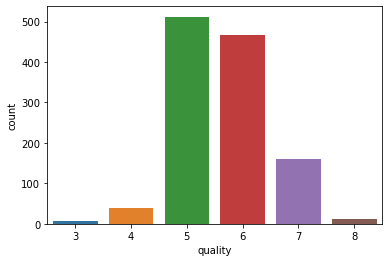

In [4]:
sns.countplot(x='quality', data=trainset);
trainset.quality.value_counts()

6    170
5    169
7     40
4     14
8      5
3      2
Name: quality, dtype: int64

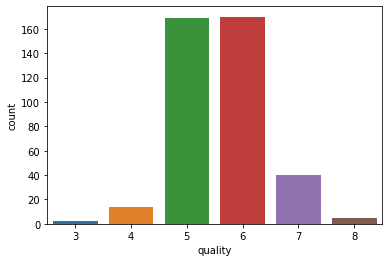

In [5]:
sns.countplot(x='quality', data=testset);
testset.quality.value_counts()

In [6]:
def preprocessing(df):
    
    df['good_vin'] = df.quality > 6.5
    
    X = df.drop(['quality', 'good_vin'], axis=1)
    y = df['good_vin']
    
    print(y.value_counts())
    
    return X, y

In [7]:
X_train, y_train = preprocessing(trainset)

False    1027
True      172
Name: good_vin, dtype: int64


In [8]:
X_test, y_test = preprocessing(testset)

False    355
True      45
Name: good_vin, dtype: int64


# Procédure d'évaluation

In [9]:
from sklearn.metrics import f1_score, plot_confusion_matrix, plot_roc_curve#, classification_report
from sklearn.model_selection import learning_curve

In [52]:
def evaluation(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_test = f1_score(y_test, y_pred, average='macro')
    print(f'{model[-1].__class__.__name__ :<25} {round(f1_test,3)} for f1_macro')
    
    fig, ax = plt.subplots(1, 3, figsize = (16,4))
    fig.subplots_adjust(top=0.85)
    ax[0].set_title('Confusion matrix')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax[0])
    ax[1].set_title('ROC curve')
    plot_roc_curve(model, X_test, y_test, ax=ax[1])
    ax[2].set_title('Learning curve')
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv = 4,
                                               scoring = 'f1_weighted', # like f1_macro
                                               train_sizes = np.linspace(0.1, 1, 10))
    ax[2].plot(N, train_score.mean(axis=1), label='train score')
    ax[2].plot(N, val_score.mean(axis=1), label='validation score')
    
    plt.suptitle(model[-1].__class__.__name__, fontsize=14)
    plt.legend();

# Modélisation

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [47]:
RandomForest = make_pipeline(RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(AdaBoostClassifier(random_state=0))
SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
XGBoost = make_pipeline(XGBClassifier(verbosity=0, random_state=0))

In [48]:
dict_of_models = {'RandomForest': RandomForest,
                  #'AdaBoost': AdaBoost,
                  'XGBoost': XGBoost,
                  'SVM': SVM,
                  'KNN': KNN}

RandomForestClassifier    0.814 for f1_macro
XGBClassifier             0.811 for f1_macro
SVC                       0.703 for f1_macro
KNeighborsClassifier      0.728 for f1_macro


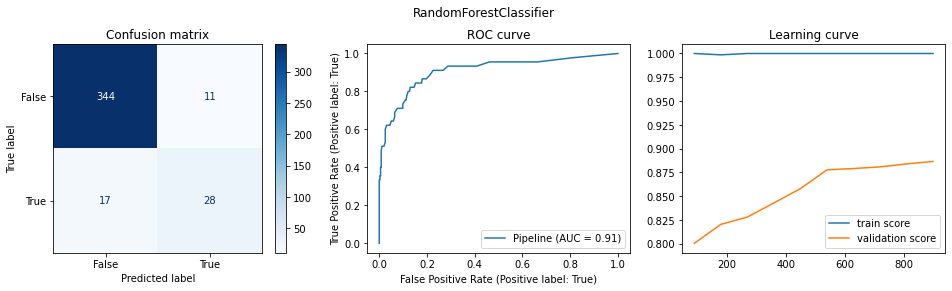

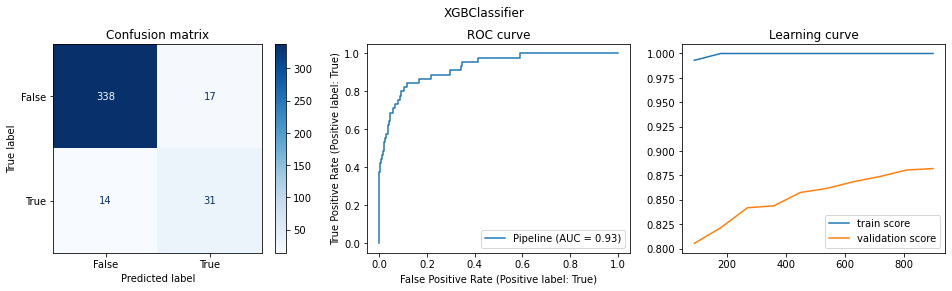

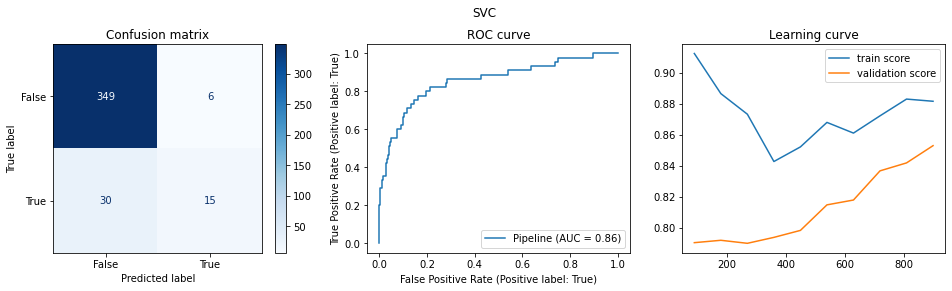

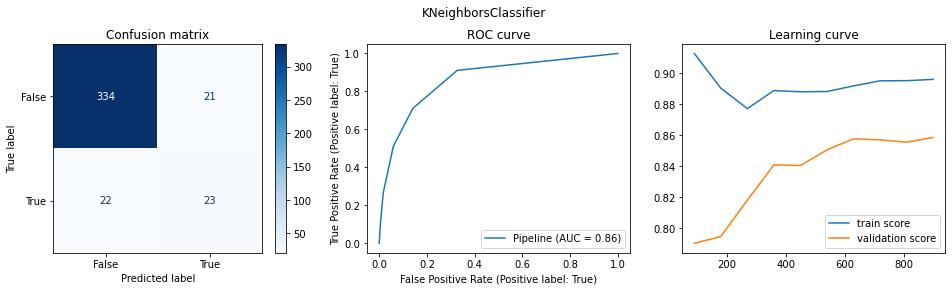

In [49]:
for name, model in dict_of_models.items():
    evaluation(model)

# Optimisation

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
score = 'f1_weighted'

## RandomForest

In [16]:
params_rf = {
    'randomforestclassifier__class_weight':['balanced'],
    'randomforestclassifier__criterion' :['entropy','gini'],
    'randomforestclassifier__n_estimators':[50,100,200,400,600,800],
    'randomforestclassifier__max_depth':[None,3,6,10,14,18]
}
grid_rf = RandomizedSearchCV(RandomForest, params_rf, scoring=score, cv=4, n_iter=100)
grid_rf.fit(X_train, y_train)
print('Best params_rf:',grid_rf.best_params_)
print('\nBest score:', grid_rf.best_score_)

Best params_rf: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__class_weight': 'balanced'}

Best score: 0.8951995653017378


RandomForestClassifier    0.783 for f1_macro


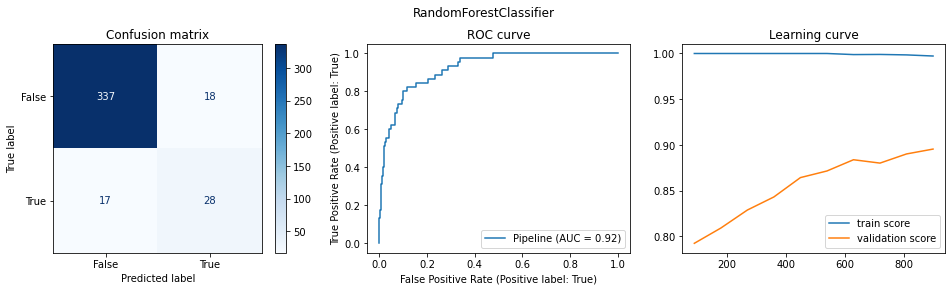

In [17]:
evaluation(grid_rf.best_estimator_)

## AdaBoost

In [18]:
# params_ada = {}
# grid_ada = RandomizedSearchCV(AdaBoost, params_ada, scoring=score, cv=4, n_iter=100)
# grid_ada.fit(X_train, y_train)
# print('Best params_ada:',grid_ada.best_params_)
# print('\nBest score:', grid_ada.best_score_)

In [19]:
# evaluation(grid_ada.best_estimator_)

## XGBoost

In [ ]:
# params_xgb = {}
# grid_xgb = RandomizedSearchCV(XGBoost, params_xgb, scoring=score, cv=4, n_iter=100)
# grid_xgb.fit(X_train, y_train)
# print('Best params_xgb:',grid_xgb.best_params_)
# print('\nBest score:', grid_xgb.best_score_)

XGBClassifier             0.811 for f1_macro


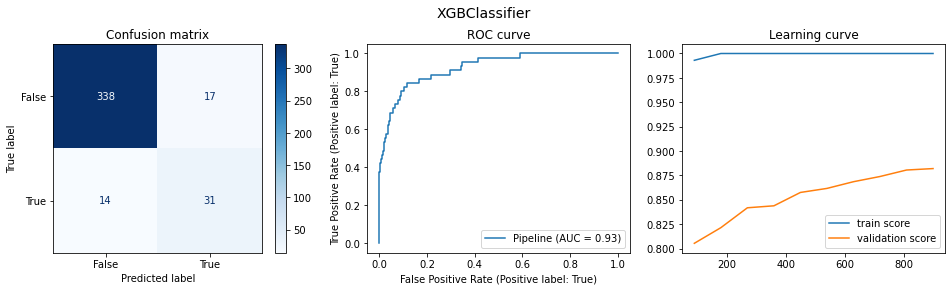

In [53]:
evaluation(XGBoost)
# evaluation(grid_xgb.best_estimator_)

## SVM

In [20]:
params_svc = {
    'svc__class_weight':['balanced', None],
    'svc__C':[10,50,100,250,500,750,1500]
}
grid_svm = GridSearchCV(SVM, params_svc, scoring=score, cv=4)
grid_svm.fit(X_train, y_train)
print('Best params_svc:',grid_svm.best_params_)
print('\nBest score:', grid_svm.best_score_)

Best params_svc: {'svc__C': 50, 'svc__class_weight': None}

Best score: 0.8754473123745758


SVC                       0.767 for f1_macro


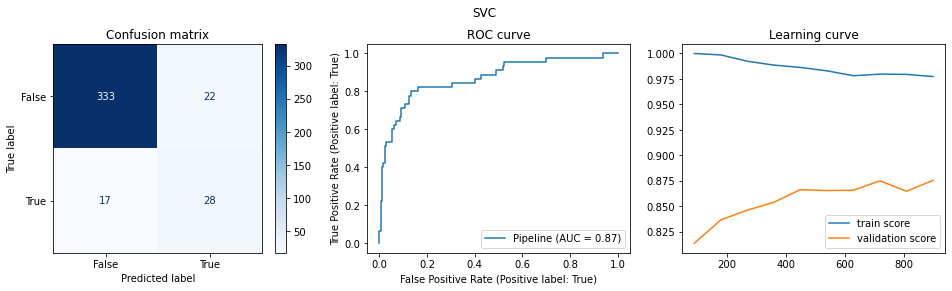

In [21]:
evaluation(grid_svm.best_estimator_)

## KNN

In [22]:
params_knn = {
    'kneighborsclassifier__weights':['distance', 'uniform'],
    'kneighborsclassifier__n_neighbors':list(range(1,25))
}
grid_knn = GridSearchCV(KNN, params_knn, scoring=score)
grid_knn.fit(X_train, y_train)
print('Best params_knn:',grid_knn.best_params_)
print('\nBest score:', grid_knn.best_score_)

Best params_knn: {'kneighborsclassifier__n_neighbors': 16, 'kneighborsclassifier__weights': 'distance'}

Best score: 0.8917761546942142


KNeighborsClassifier      0.787 for f1_macro


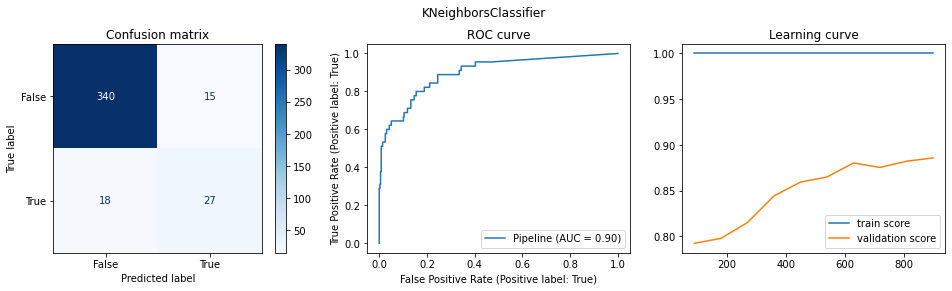

In [23]:
evaluation(grid_knn.best_estimator_)

# Precision Recall Curve

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
precision, recall, threshold = precision_recall_curve(y_test, grid_svm.best_estimator_.decision_function(X_test))

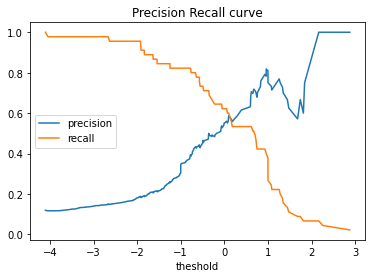

In [26]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.xlabel('theshold')
plt.legend()
plt.title('Precision Recall curve');

In [27]:
def model_final(model, X, threshold):
    return model.decision_function(X) > threshold

# Bilan